In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#RESNET50 
#TRY 1

In [ ]:
import os
import pathlib
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras import Model
from keras.applications.resnet50 import ResNet50, preprocess_input  
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import *
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
SEED = 999

def build_network(base_model, classes):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(units=1024)(x)  # 1024 neurons
    x = ReLU()(x)
    #x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=classes)(x)
    output = Softmax()(x)
    return output

def load_images_and_labels(image_paths, target_size=(224, 224)):
    images = []
    labels = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image)

        label = image_path.split(os.path.sep)[-2]

        images.append(image)
        labels.append(label)

    if not labels:
        raise ValueError("No labels loaded. Check your dataset.")

    return np.array(images), np.array(labels)


Epoch 1/20
86/86 [==============================] - 34s 353ms/step - loss: 0.9931 - accuracy: 0.7099 - val_loss: 0.8353 - val_accuracy: 0.7922
Epoch 2/20
86/86 [==============================] - 28s 326ms/step - loss: 0.6174 - accuracy: 0.7961 - val_loss: 0.5478 - val_accuracy: 0.8543
Epoch 3/20
86/86 [==============================] - 28s 330ms/step - loss: 0.5533 - accuracy: 0.8111 - val_loss: 0.5850 - val_accuracy: 0.8196
Epoch 4/20
86/86 [==============================] - 29s 333ms/step - loss: 0.4704 - accuracy: 0.8495 - val_loss: 0.6026 - val_accuracy: 0.8398
Epoch 5/20
86/86 [==============================] - 28s 328ms/step - loss: 0.4089 - accuracy: 0.8637 - val_loss: 0.5738 - val_accuracy: 0.8254
Epoch 6/20
86/86 [==============================] - 28s 327ms/step - loss: 0.3781 - accuracy: 0.8670 - val_loss: 0.6523 - val_accuracy: 0.8254
Epoch 7/20
86/86 [==============================] - 28s 327ms/step - loss: 0.3759 - accuracy: 0.8703 - val_loss: 0.5053 - val_accuracy: 0.8615

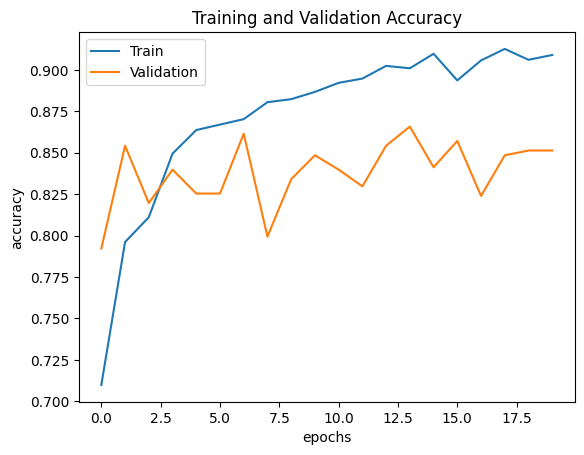

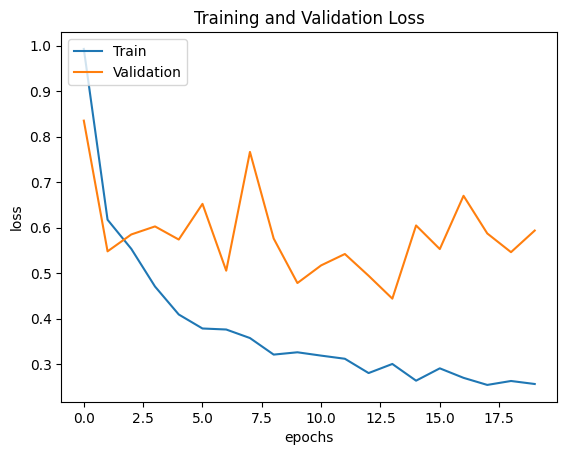

22/22 [==============================] - 2s 56ms/step
Classification Report:
                   precision    recall  f1-score   support

           Ajloun       0.88      0.73      0.80        41
           Jerash       0.88      0.87      0.88       154
            Petra       0.78      0.92      0.84       123
RomanAmphitheater       0.89      0.64      0.74        66
          UmmQais       0.98      0.95      0.96       172
          WadiRum       0.91      0.99      0.95       137

         accuracy                           0.89       693
        macro avg       0.89      0.85      0.86       693
     weighted avg       0.89      0.89      0.89       693



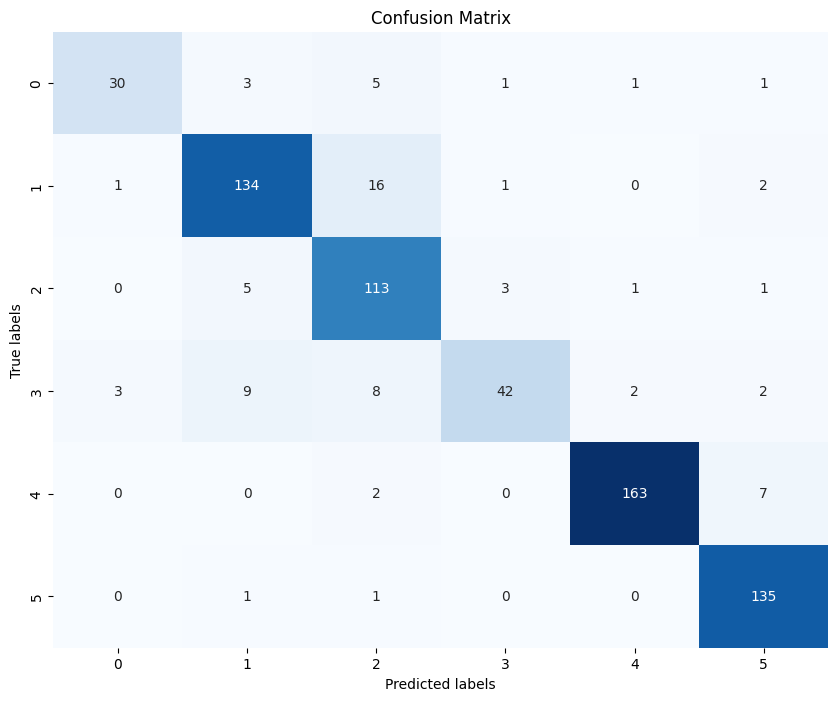

In [11]:

def main():
    dataset_path = pathlib.Path("/kaggle/input/places")
    files_pattern = (dataset_path / 'Data' / '*' / '*.png')
    image_paths = [*glob(str(files_pattern))]
    CLASSES = {p.split(os.path.sep)[-2] for p in image_paths}

    X, y = load_images_and_labels(image_paths, target_size=(224, 224))
    X = preprocess_input(X)  
    y = LabelBinarizer().fit_transform(y)
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=SEED)

    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

    for layer in base_model.layers:
        layer.trainable = False

    model = build_network(base_model, len(CLASSES))
    model = Model(base_model.input, model)

    BATCH_SIZE = 32
    augmenter = ImageDataGenerator(rotation_range=60, horizontal_flip=True, width_shift_range=0.1,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
    train_generator = augmenter.flow(X_train, y_train, BATCH_SIZE)

    EPOCHS = 20
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-3), metrics=["accuracy"])

    history = model.fit(train_generator, steps_per_epoch=len(X_train) // BATCH_SIZE, validation_data=(X_test, y_test), epochs=EPOCHS)
    
    # Save model weights
    model_weights_save_path = '/kaggle/working/fine_tuned_model_resnet50_weights.h5'
    model.save_weights(model_weights_save_path)
    print(f"Model weights saved to: {model_weights_save_path}")

    result = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {result[1]}')

    for layer in base_model.layers[165:]:
        layer.trainable = True

    EPOCHS = 50
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=1e-3), metrics=['accuracy'])

    history_fine_tuned = model.fit(train_generator, steps_per_epoch=len(X_train) // BATCH_SIZE, validation_data=(X_test, y_test), epochs=EPOCHS)
    
    # Save fine-tuned model weights
    fine_tuned_model_weights_save_path = '/kaggle/working/fine_tuned_model_resnet50_weights_fine_tuned.h5'
    model.save_weights(fine_tuned_model_weights_save_path)
    print(f"Fine-tuned model weights saved to: {fine_tuned_model_weights_save_path}")

    result_fine_tuned = model.evaluate(X_test, y_test)
    print(f'Fine-tuned Test accuracy: {result_fine_tuned[1]}')
    
    # Plot learning curves
    plot_learning_curve(history, 'Training and Validation Accuracy', 'accuracy', 'epochs', 'accuracy')
    plot_learning_curve(history, 'Training and Validation Loss', 'loss', 'epochs', 'loss')

    # Predict the classes
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Define class names
    class_names = ["Ajloun", "Jerash", "Petra", "RomanAmphitheater", "UmmQais", "WadiRum"]

    # Print classification report with class names
    print("Classification Report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    return history, history_fine_tuned

def plot_learning_curve(history, title, ylabel, xlabel, filename):
    plt.plot(history.history[ylabel])
    plt.plot(history.history[f'val_{ylabel}'])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(f'/kaggle/working/{filename}.png')
    plt.show()

if __name__ == '__main__':
    history, history_fine_tuned = main()


In [ ]:
#TRY 2

In [ ]:
import os
import pathlib
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras import Model
from keras.applications.resnet50 import ResNet50, preprocess_input  # Fix import
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import *
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
SEED = 999

def build_network(base_model, classes):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(units=1024)(x)  # Changed to 1024 neurons
    x = ReLU()(x)
    #x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=classes)(x)
    output = Softmax()(x)
    return output

def load_images_and_labels(image_paths, target_size=(224, 224)):
    images = []
    labels = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image)

        label = image_path.split(os.path.sep)[-2]

        images.append(image)
        labels.append(label)

    if not labels:
        raise ValueError("No labels loaded. Check your dataset.")

    return np.array(images), np.array(labels)

Epoch 1/20
86/86 [==============================] - 33s 344ms/step - loss: 1.9760 - accuracy: 0.5857 - val_loss: 0.6614 - val_accuracy: 0.7489
Epoch 2/20
86/86 [==============================] - 28s 325ms/step - loss: 0.8206 - accuracy: 0.7231 - val_loss: 0.6153 - val_accuracy: 0.7792
Epoch 3/20
86/86 [==============================] - 28s 323ms/step - loss: 0.6985 - accuracy: 0.7592 - val_loss: 0.7102 - val_accuracy: 0.7662
Epoch 4/20
86/86 [==============================] - 28s 325ms/step - loss: 0.6171 - accuracy: 0.7786 - val_loss: 0.5385 - val_accuracy: 0.8211
Epoch 5/20
86/86 [==============================] - 28s 327ms/step - loss: 0.5939 - accuracy: 0.8031 - val_loss: 0.5318 - val_accuracy: 0.8167
Epoch 6/20
86/86 [==============================] - 28s 327ms/step - loss: 0.5395 - accuracy: 0.8122 - val_loss: 0.4701 - val_accuracy: 0.8384
Epoch 7/20
86/86 [==============================] - 28s 328ms/step - loss: 0.5044 - accuracy: 0.8286 - val_loss: 0.5148 - val_accuracy: 0.8297

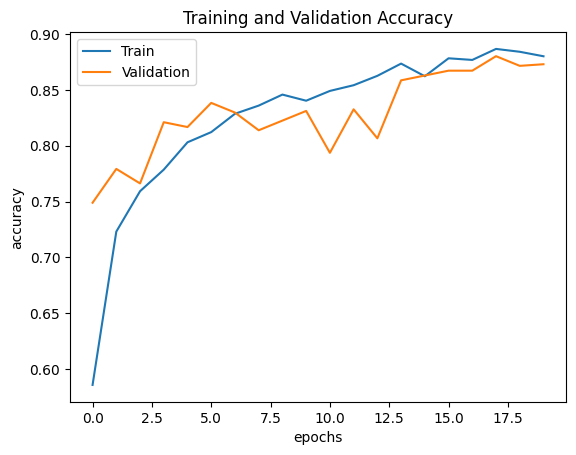

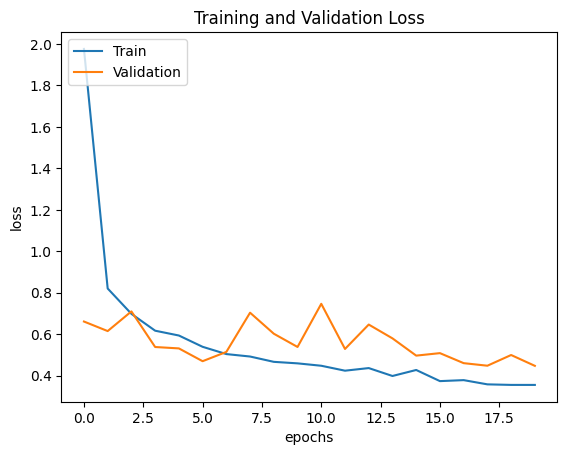

22/22 [==============================] - 2s 56ms/step
Classification Report:
                   precision    recall  f1-score   support

           Ajloun       0.80      0.68      0.74        41
           Jerash       0.84      0.86      0.85       154
            Petra       0.77      0.90      0.83       123
RomanAmphitheater       0.87      0.61      0.71        66
          UmmQais       0.98      0.97      0.98       172
          WadiRum       0.94      0.96      0.95       137

         accuracy                           0.88       693
        macro avg       0.87      0.83      0.84       693
     weighted avg       0.88      0.88      0.88       693



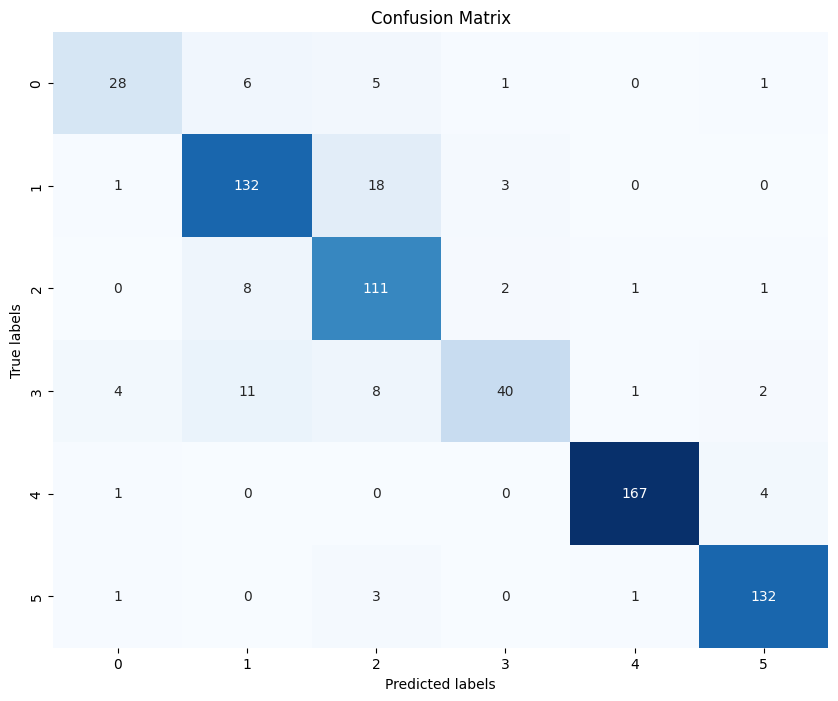

In [12]:




def main():
    dataset_path = pathlib.Path("/kaggle/input/places")
    files_pattern = (dataset_path / 'Data' / '*' / '*.png')
    image_paths = [*glob(str(files_pattern))]
    CLASSES = {p.split(os.path.sep)[-2] for p in image_paths}

    X, y = load_images_and_labels(image_paths, target_size=(224, 224))
    X = preprocess_input(X)  
    y = LabelBinarizer().fit_transform(y)
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=SEED)

    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

    for layer in base_model.layers:
        layer.trainable = False

    model = build_network(base_model, len(CLASSES))
    model = Model(base_model.input, model)

    BATCH_SIZE = 32
    augmenter = ImageDataGenerator(rotation_range=60, horizontal_flip=True, width_shift_range=0.1,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
    train_generator = augmenter.flow(X_train, y_train, BATCH_SIZE)

    EPOCHS = 20
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-3), metrics=["accuracy"])

    history = model.fit(train_generator, steps_per_epoch=len(X_train) // BATCH_SIZE, validation_data=(X_test, y_test), epochs=EPOCHS)
    
    # Save model weights
    model_weights_save_path = '/kaggle/working/fine_tuned_model_resnet50_weights2.h5'
    model.save_weights(model_weights_save_path)
    print(f"Model weights saved to: {model_weights_save_path}")

    result = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {result[1]}')

    for layer in base_model.layers[165:]:
        layer.trainable = True

    EPOCHS = 40
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=1e-3), metrics=['accuracy'])

    history_fine_tuned = model.fit(train_generator, steps_per_epoch=len(X_train) // BATCH_SIZE, validation_data=(X_test, y_test), epochs=EPOCHS)
    
    # Save fine-tuned model weights
    fine_tuned_model_weights_save_path = '/kaggle/working/fine_tuned_model_resnet50_weights_fine_tuned2.h5'
    model.save_weights(fine_tuned_model_weights_save_path)
    print(f"Fine-tuned model weights saved to: {fine_tuned_model_weights_save_path}")

    result_fine_tuned = model.evaluate(X_test, y_test)
    print(f'Fine-tuned Test accuracy: {result_fine_tuned[1]}')
    
    # Plot learning curves
    plot_learning_curve(history, 'Training and Validation Accuracy', 'accuracy', 'epochs', 'accuracy')
    plot_learning_curve(history, 'Training and Validation Loss', 'loss', 'epochs', 'loss')

    # Predict the classes
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Define class names
    class_names = ["Ajloun", "Jerash", "Petra", "RomanAmphitheater", "UmmQais", "WadiRum"]

    # Print classification report with class names
    print("Classification Report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    return history, history_fine_tuned

def plot_learning_curve(history, title, ylabel, xlabel, filename):
    plt.plot(history.history[ylabel])
    plt.plot(history.history[f'val_{ylabel}'])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(f'/kaggle/working/{filename}.png')
    plt.show()

if __name__ == '__main__':
    history, history_fine_tuned = main()


In [ ]:
#TRY 3

In [ ]:
import os
import pathlib
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras import Model
from keras.applications.resnet50 import ResNet50, preprocess_input  # Fix import
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.image import *
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [ ]:
SEED = 999

def build_network(base_model, classes):
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(units=1024)(x)  # 1024 neurons
    x = ReLU()(x)
    # x = BatchNormalization()(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=classes)(x)
    output = Softmax()(x)
    return output

def load_images_and_labels(image_paths, target_size=(224, 224)):
    images = []
    labels = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image)

        label = image_path.split(os.path.sep)[-2]

        images.append(image)
        labels.append(label)

    if not labels:
        raise ValueError("No labels loaded. Check your dataset.")

    return np.array(images), np.array(labels)


Epoch 1/20
86/86 [==============================] - 34s 351ms/step - loss: 2.0646 - accuracy: 0.5740 - val_loss: 1.2592 - val_accuracy: 0.6421
Epoch 2/20
86/86 [==============================] - 29s 331ms/step - loss: 0.8256 - accuracy: 0.7315 - val_loss: 0.5388 - val_accuracy: 0.8009
Epoch 3/20
86/86 [==============================] - 28s 328ms/step - loss: 0.7104 - accuracy: 0.7629 - val_loss: 0.5052 - val_accuracy: 0.8297
Epoch 4/20
86/86 [==============================] - 28s 328ms/step - loss: 0.6182 - accuracy: 0.7830 - val_loss: 0.7301 - val_accuracy: 0.7835
Epoch 5/20
86/86 [==============================] - 29s 332ms/step - loss: 0.5980 - accuracy: 0.7969 - val_loss: 0.4936 - val_accuracy: 0.8355
Epoch 6/20
86/86 [==============================] - 28s 329ms/step - loss: 0.5479 - accuracy: 0.8191 - val_loss: 0.4959 - val_accuracy: 0.8398
Epoch 7/20
86/86 [==============================] - 28s 326ms/step - loss: 0.5174 - accuracy: 0.8210 - val_loss: 0.5551 - val_accuracy: 0.8312

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to: /kaggle/working/fine_tuned_model_resnet50_new.h5
22/22 [==============================] - 1s 59ms/step - loss: 0.4463 - accuracy: 0.8802
Test accuracy: 0.8802309036254883
Epoch 1/40
86/86 [==============================] - 35s 349ms/step - loss: 0.2829 - accuracy: 0.8999 - val_loss: 0.4202 - val_accuracy: 0.8773
Epoch 2/40
86/86 [==============================] - 28s 329ms/step - loss: 0.2561 - accuracy: 0.9079 - val_loss: 0.4119 - val_accuracy: 0.8788
Epoch 3/40
86/86 [==============================] - 28s 328ms/step - loss: 0.2668 - accuracy: 0.9072 - val_loss: 0.4122 - val_accuracy: 0.8730
Epoch 4/40
86/86 [==============================] - 28s 330ms/step - loss: 0.2346 - accuracy: 0.9138 - val_loss: 0.4051 - val_accuracy: 0.8802
Epoch 5/40
86/86 [==============================] - 29s 332ms/step - loss: 0.2361 - accuracy: 0.9167 - val_loss: 0.4173 - val_accuracy: 0.8773
Epoch 6/40
86/86 [==============================] - 29s 334ms/step - loss: 0.2417 - accuracy: 0.91

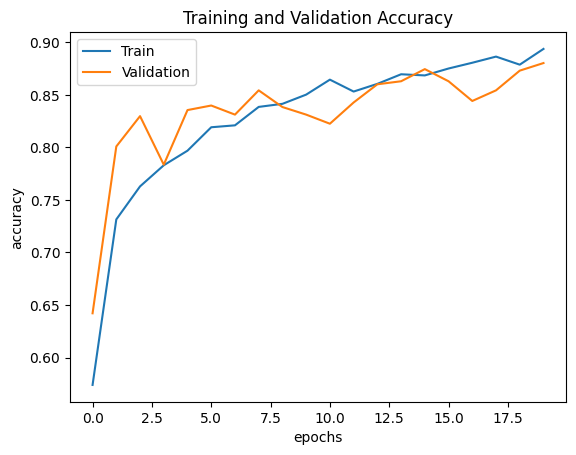

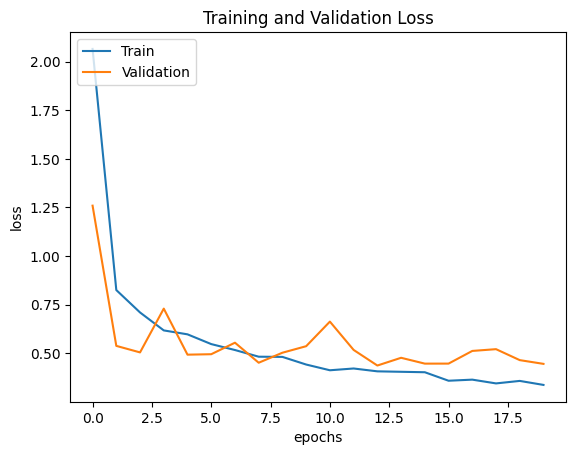

22/22 [==============================] - 2s 56ms/step
Classification Report:
                   precision    recall  f1-score   support

           Ajloun       0.82      0.68      0.75        41
           Jerash       0.83      0.88      0.86       154
            Petra       0.77      0.93      0.84       123
RomanAmphitheater       0.89      0.50      0.64        66
          UmmQais       0.98      0.94      0.96       172
          WadiRum       0.92      0.97      0.95       137

         accuracy                           0.87       693
        macro avg       0.87      0.82      0.83       693
     weighted avg       0.88      0.87      0.87       693



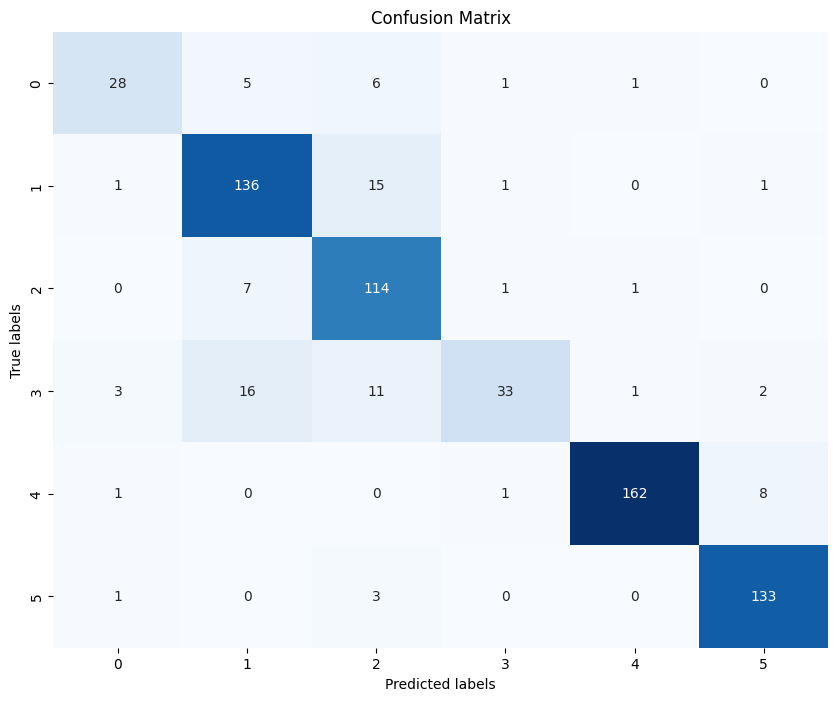

In [14]:


def main():
    dataset_path = pathlib.Path("/kaggle/input/places")
    files_pattern = (dataset_path / 'Data' / '*' / '*.png')
    image_paths = [*glob(str(files_pattern))]
    CLASSES = {p.split(os.path.sep)[-2] for p in image_paths}

    X, y = load_images_and_labels(image_paths, target_size=(224, 224))
    X = preprocess_input(X)  # Adjust preprocessing for ResNet50
    y = LabelBinarizer().fit_transform(y)
    (X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=SEED)

    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

    for layer in base_model.layers:
        layer.trainable = False

    model = build_network(base_model, len(CLASSES))
    model = Model(base_model.input, model)

    BATCH_SIZE = 32
    augmenter = ImageDataGenerator(rotation_range=60, horizontal_flip=True, width_shift_range=0.1,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
    train_generator = augmenter.flow(X_train, y_train, BATCH_SIZE)

    EPOCHS = 20
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=1e-3), metrics=["accuracy"])

    history = model.fit(train_generator, steps_per_epoch=len(X_train) // BATCH_SIZE, validation_data=(X_test, y_test), epochs=EPOCHS)

    # Save the entire model
    model_save_path = '/kaggle/working/fine_tuned_model_resnet50_new.h5'
    model.save(model_save_path)
    print(f"Model saved to: {model_save_path}")

    result = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {result[1]}')

    for layer in base_model.layers[165:]:
        layer.trainable = True

    EPOCHS = 40
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=1e-3), metrics=['accuracy'])

    history_fine_tuned = model.fit(train_generator, steps_per_epoch=len(X_train) // BATCH_SIZE, validation_data=(X_test, y_test), epochs=EPOCHS)

    # Save fine-tuned model weights
    fine_tuned_model_weights_save_path = '/kaggle/working/fine_tuned_model_resnet50_weight_new.h5'
    model.save_weights(fine_tuned_model_weights_save_path)
    print(f"Fine-tuned model weights saved to: {fine_tuned_model_weights_save_path}")

    result_fine_tuned = model.evaluate(X_test, y_test)
    print(f'Fine-tuned Test accuracy: {result_fine_tuned[1]}')

    # Plot learning curves
    plot_learning_curve(history, 'Training and Validation Accuracy', 'accuracy', 'epochs', 'accuracy')
    plot_learning_curve(history, 'Training and Validation Loss', 'loss', 'epochs', 'loss')

    # Predict the classes
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Define class names
    class_names = ["Ajloun", "Jerash", "Petra", "RomanAmphitheater", "UmmQais", "WadiRum"]

    # Print classification report with class names
    print("Classification Report:")
    print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    return history, history_fine_tuned

def plot_learning_curve(history, title, ylabel, xlabel, filename):
    plt.plot(history.history[ylabel])
    plt.plot(history.history[f'val_{ylabel}'])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig(f'/kaggle/working/{filename}.png')
    plt.show()

if __name__ == '__main__':
    history, history_fine_tuned = main()
